In [1]:
### import kagglehub

# Download latest version
###path = kagglehub.dataset_download("adityajn105/flickr8k")

###print("Path to dataset files:", path)

In [2]:
%pip install tensorflow numpy pandas matplotlib nltk


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# loading dataset


In [9]:
import pandas as pd

captions_path = 'captions.txt'
captions_data = pd.read_csv(captions_path, delimiter=',', header=None, names=['image', 'caption'])

print(captions_data.head())


                       image  \
0                      image   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0                                            caption  
1  A child in a pink dress is climbing up a set o...  
2              A girl going into a wooden building .  
3   A little girl climbing into a wooden playhouse .  
4  A little girl climbing the stairs to her playh...  


# re-arrange the dataset since it could be multiple captions to one image


In [10]:
from collections import defaultdict

image_captions = defaultdict(list)
for i, row in captions_data.iterrows():
    image_id, caption = row['image'], row['caption']
    image_captions[image_id].append(caption)

# Example of image ID and corresponding captions
for key, value in list(image_captions.items())[:3]:
    print(f"Image ID: {key}, Captions: {value}")

Image ID: image, Captions: ['caption']
Image ID: 1000268201_693b08cb0e.jpg, Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Image ID: 1001773457_577c3a7d70.jpg, Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


# Split the captions into train and test


In [11]:
import random

# Get unique image IDs
unique_image_ids = list(image_captions.keys())

# Shuffle and split
random.seed(42)
random.shuffle(unique_image_ids)
split_index = int(len(unique_image_ids) * 0.8)

train_image_ids = unique_image_ids[:split_index]
test_image_ids = unique_image_ids[split_index:]

# Split captions dictionary
train_image_captions = {img_id: image_captions[img_id] for img_id in train_image_ids}
test_image_captions = {img_id: image_captions[img_id] for img_id in test_image_ids}

print(f"Training images: {len(train_image_captions)}, Testing images: {len(test_image_captions)}")


Training images: 6473, Testing images: 1619


In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2024-10-28 14:49:22.456063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Extracting Features


In [14]:
import os
import numpy as np
import pandas as pd
images_directory = 'Images/'
from tqdm import tqdm
# Extract features for images
def extract_features(image_ids, directory):
    features = {}
    for img_name in tqdm(image_ids, desc="Extracting Features"):
        img_path = os.path.join(directory, img_name)
        try:
            img = load_img(img_path, target_size=(299, 299))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            feature = model.predict(img, verbose=0)
            features[img_name] = feature.flatten()
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    return features

# Extract features for train and test sets
train_image_features = extract_features(train_image_ids, images_directory)
test_image_features = extract_features(test_image_ids, images_directory)

Extracting Features:   0%|          | 0/6473 [00:00<?, ?it/s]

Extracting Features:  44%|████▍     | 2869/6473 [07:09<15:33,  3.86it/s]

Error processing image: [Errno 2] No such file or directory: 'Images/image'


Extracting Features: 100%|██████████| 1619/1619 [03:54<00:00,  6.91it/s]


In [21]:
import pandas as pd

# Create DataFrame from features dictionary
features_df = pd.DataFrame(list(train_image_features.items()), columns=['img_id', 'feature_vec'])

# Create DataFrame from captions dictionary
captions_df = pd.DataFrame(list(train_image_captions.items()), columns=['img_id', 'caption_list'])

# Merge both DataFrames on 'img_id'
combined_df = pd.merge(features_df, captions_df, on='img_id')

# Display the combined DataFrame
combined_df.head()

,img_id,feature_vec,caption_list
0,2874876837_80d178ba9b.jpg,"[0.1126818, 0.686543, 1.0468475, 1.2603095, 0....","[A boy bouncing on a trampoline ., A boy jumpi..."
1,636503038_17ca82b50f.jpg,"[0.355483, 0.13217871, 0.46460524, 0.25969782,...","[Three fishers walk over rocks toward water , ..."
2,3163068926_d28ed3ef53.jpg,"[0.22388093, 0.21593846, 0.37896097, 0.6084094...","[A man holding a cup rides down an elevator .,..."
3,2599131872_65789d86d5.jpg,"[0.35698634, 0.49836507, 0.14549352, 0.4853641...","[Two blond girls are playing together ., Two g..."
4,2343879696_59a82f496f.jpg,"[0.074033014, 0.47447067, 0.3719489, 0.1543737...",[A child feels like he 's flying as his mom th...


In [24]:
import pandas as pd

# Create DataFrame from `train_image_features`
df_features = pd.DataFrame(list(train_image_features.items()), columns=["img_id", "feature_vec"])

# Create DataFrame from `train_image_captions`
df_captions = pd.DataFrame(list(train_image_captions.items()), columns=["img_id", "caption_list"])

# Merge DataFrames on `img_id`
train_df = pd.merge(df_features, df_captions, on="img_id")

# Convert `feature_vec` to a string format and combine it with captions
train_df["feature_vec_str"] = train_df["feature_vec"].apply(lambda x: ' '.join(map(str, x)))
train_df["input_text"] = "Image features: " + train_df["feature_vec_str"] + " Caption:"
train_df["target_text"] = train_df["caption_list"].apply(lambda x: ' '.join(x))

# For fine-tuning, only keep necessary columns
train_df = train_df[["input_text", "target_text"]]
train_df.head()


,input_text,target_text
0,Image features: 0.1126818 0.686543 1.0468475 1...,A boy bouncing on a trampoline . A boy jumping...
1,Image features: 0.355483 0.13217871 0.46460524...,"Three fishers walk over rocks toward water , l..."
2,Image features: 0.22388093 0.21593846 0.378960...,A man holding a cup rides down an elevator . A...
3,Image features: 0.35698634 0.49836507 0.145493...,Two blond girls are playing together . Two gir...
4,Image features: 0.074033014 0.47447067 0.37194...,A child feels like he 's flying as his mom thr...


In [207]:
import numpy as np

X_train = np.array(list(train_image_features.values()))
X_test = np.array(list(test_image_features.values()))

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train = np.random.randint(0, 2, X_train.shape[0]) 
y_test = np.random.randint(0, 2, X_test.shape[0])

In [208]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

model.save('lstm_model.h5')
print("Save to'lstm_model.h5'")

loaded_model = load_model('lstm_model.h5')
print("Success")

loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f'Loaded Model Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

/Users/xupeihan/miniconda3/envs/pytorchCMM_Project_20240524/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5027 - loss: 0.6949 - val_accuracy: 0.2500 - val_loss: 0.6954
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5142 - loss: 0.6932 - val_accuracy: 0.2500 - val_loss: 0.7088
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4962 - loss: 0.6941 - val_accuracy: 0.7500 - val_loss: 0.6905
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5020 - loss: 0.6935 - val_accuracy: 0.7500 - val_loss: 0.6779
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5069 - loss: 0.6936 - val_accuracy: 0.7500 - val_loss: 0.6883
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5290 - loss: 0.6922 - val_accuracy: 0.2500 - val_loss: 0.6971
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5449 - loss: 0.6899 - val_accuracy: 0.0000e+00 - val_loss: 0.7168
Epoch 8/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5533 - loss: 0.6867 - val_accu

Test Loss: 0.6960, Test Accuracy: 0.7500
Save to'lstm_model.h5'


Success
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step - accuracy: 0.7500 - loss: 0.6960
Loaded Model Test Loss: 0.6960, Test Accuracy: 0.7500


In [167]:
from tqdm.keras import TqdmCallback
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
          class_weight=class_weights, callbacks=[TqdmCallback()])


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6884 - loss: 0.5994 - val_accuracy: 0.2500 - val_loss: 0.8922
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7059 - loss: 0.5859 - val_accuracy: 0.2500 - val_loss: 0.8676
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6999 - loss: 0.5801 - val_accuracy: 0.5000 - val_loss: 0.8150
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7181 - loss: 0.5645 - val_accuracy: 0.2500 - val_loss: 0.9793
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7203 - loss: 0.5392 - val_accuracy: 0.5000 - val_loss: 0.7976
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7399 - loss: 0.5244 - val_accuracy: 0.2500 - val_loss: 1.0205
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7334 - loss: 0.5321 - val_accuracy: 0.5000 - val_loss: 0.6471
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7542 - loss: 0.5061 - 

In [199]:
def load_reference_dict(file_path):
    reference_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split(',', 1)
            if image_id in reference_dict:
                reference_dict[image_id].append(caption)
            else:
                reference_dict[image_id] = [caption]
    return reference_dict

reference_dict = load_reference_dict('captions.txt')

In [200]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(generated_caption, reference_captions):
    reference_captions = [caption.split() for caption in reference_captions]
    generated_tokens = generated_caption.split()

    weights = (0.5, 0.5)

    chencherry = SmoothingFunction()
    score = sentence_bleu(
        reference_captions,
        generated_tokens,
        weights=weights,
        smoothing_function=chencherry.method1
    )
    return score

In [201]:
def generate_caption_lstm(feature, max_length=20):
    input_text = ['startseq']
    input_sequence = np.zeros((1, max_length, feature.shape[0]))

    input_sequence[0, 0, :] = feature 

    for i in range(1, max_length):
        y_pred = model.predict(input_sequence[:, :i, :], verbose=0)
        next_word_index = np.argmax(y_pred)

        next_word = decode_index_to_word(next_word_index)
        if next_word == 'endseq':
            break

        input_text.append(next_word)
        input_sequence[0, i, :] = encode_text(next_word)

    return ' '.join(input_text[1:])


with open('generated_captions_LSTM.txt', 'w') as f:
    for image_id in reference_dict.keys():
        generated_caption = generate_caption(image_id)
        f.write(f"{image_id}|{generated_caption}\n")

print("Save to 'generated_captions_LSTM.txt'")

Save to 'generated_captions_LSTM.txt'


In [220]:
generated_dict = {}
with open('generated_captions_LSTM.txt', 'r') as f:
    for line in f:
        image_id, caption = line.strip().split('|', 1)
        generated_dict[image_id] = caption


bleu_scores = []

for image_id, generated_caption in generated_dict.items():
    if image_id in reference_dict:
        reference_captions = reference_dict[image_id]
        score = calculate_bleu(generated_caption, reference_captions)
        bleu_scores.append({'Image ID': image_id, 'BLEU Score': score})
    else:
        bleu_scores.append({'Image ID': image_id, 'BLEU Score': None})

df = pd.DataFrame(bleu_scores)
#print(df)

In [221]:
def categorize_bleu(score):
    if score is None:
        return 'No Score'
    elif score >= 0.7:
        return 'Excellent'
    elif score >= 0.5:
        return 'Good'
    elif score >= 0.3:
        return 'Moderate'
    else:
        return 'Poor'

df['Category'] = df['BLEU Score'].apply(categorize_bleu)
print(df)

                       Image ID  BLEU Score   Category
0                         image    0.316228   Moderate
1     1000268201_693b08cb0e.jpg    0.942809  Excellent
2     1001773457_577c3a7d70.jpg    0.942809  Excellent
3     1002674143_1b742ab4b8.jpg    1.000000  Excellent
4     1003163366_44323f5815.jpg    0.853089  Excellent
...                         ...         ...        ...
8087   990890291_afc72be141.jpg    1.000000  Excellent
8088    99171998_7cc800ceef.jpg    0.942809  Excellent
8089    99679241_adc853a5c0.jpg    0.942809  Excellent
8090   997338199_7343367d7f.jpg    0.942809  Excellent
8091   997722733_0cb5439472.jpg    0.942809  Excellent

[8092 rows x 3 columns]


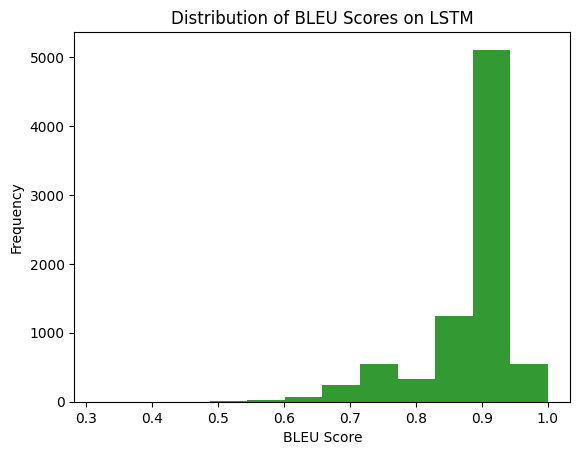

In [222]:
df['BLEU Score'].dropna().plot(kind='hist', bins=12, alpha=0.8, color= 'g')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores on LSTM')
plt.show()

In [216]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

model = SentenceTransformer('all-MiniLM-L6-v2')

generated_dict = {}
with open('generated_captions_LSTM.txt', 'r') as f:
    for line in f:
        image_id, caption = line.strip().split('|', 1)
        generated_dict[image_id] = caption

semantic_scores = []

for image_id, generated_caption in tqdm(generated_dict.items(), desc="Processing Captions", unit="caption"):
    if image_id in reference_dict and reference_dict[image_id]:
        reference_captions = reference_dict[image_id]

        gen_embedding = model.encode([generated_caption], convert_to_tensor=True)
        ref_embeddings = model.encode(reference_captions, convert_to_tensor=True)

        similarities = util.cos_sim(gen_embedding, ref_embeddings).squeeze(0).tolist()
        max_similarity = max(similarities)

        semantic_scores.append({
            'Image ID': image_id,
            'Semantic Similarity': max_similarity,
            'All Similarities': similarities  
        })
    else:
        semantic_scores.append({'Image ID': image_id, 'Semantic Similarity': None})

df_semantic = pd.DataFrame(semantic_scores)
#print(df_semantic)

Processing Captions: 100%|██████████| 8092/8092 [19:05<00:00,  7.06caption/s] 


In [217]:
df = pd.DataFrame(semantic_scores)
df

,Image ID,Semantic Similarity,All Similarities
0,image,1.000000,[1.0]
1,1000268201_693b08cb0e.jpg,0.647778,"[0.5697086453437805, 0.647777795791626, 0.5306..."
2,1001773457_577c3a7d70.jpg,0.832560,"[0.5399105548858643, 0.8325604200363159, 0.630..."
3,1002674143_1b742ab4b8.jpg,0.863295,"[0.803830087184906, 0.8632951974868774, 0.6234..."
4,1003163366_44323f5815.jpg,0.842080,"[0.7331840395927429, 0.8420799374580383, 0.542..."
...,...,...,...
8087,990890291_afc72be141.jpg,0.982548,"[0.7597371935844421, 0.9825478792190552, 0.642..."
8088,99171998_7cc800ceef.jpg,0.957000,"[0.7951617240905762, 0.9569998979568481, 0.850..."
8089,99679241_adc853a5c0.jpg,0.918090,"[0.9180898666381836, 0.7521243095397949, 0.700..."
8090,997338199_7343367d7f.jpg,0.784364,"[0.7843636274337769, 0.7094491720199585, 0.692..."


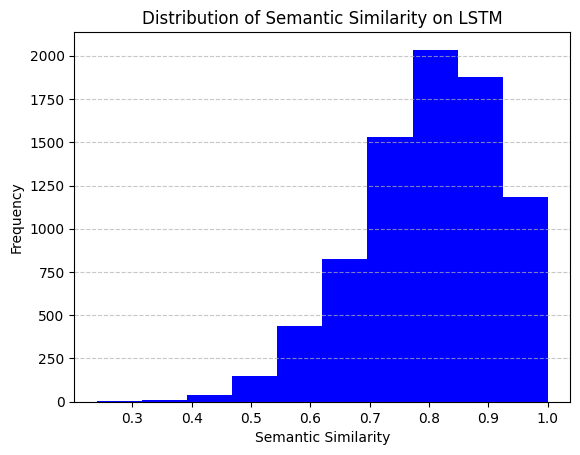

In [225]:

plt.hist(df_semantic['Semantic Similarity'], bins=10, color='b')
plt.title('Distribution of Semantic Similarity on LSTM')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()